# Introduction to arcgis.apps.dashboards module

The `arcgis.apps.dashboards` module, introduced in ArcGIS Python API v2.4.3, provides programmatic tools for managing dashboard items. It enables automation of common tasks such as:

<ul><li><b>Updating Data Sources:</b> Replace outdated or deprecated data sources without manual edits.
<li><b>Preserving Layout and Interactivity:</b> Reuse existing dashboard configurations while connecting to new datasets.</li>
<li><b>Copying and Upgrading Dashboards:</b> Create copies or upgrade dashboards to the latest supported version.</li></ul>

This module supports only modern ArcGIS Dashboards items and does not work with items created in the retired ArcGIS Dashboards Classic app. 

Tip: To check whether a dashboard is supported, you can look at its data using the item’s `get_data()` function. Dashboards with a version shown as a string (such as "4.30.0","4.31.0" and so on) or a number of 27 or higher are supported (see helper function below). If you find an older Classic dashboard (those with a version number below 27), you can update it by opening it in ArcGIS Dashboards, switching to Edit mode, and saving it.

In [ ]:
# a helper function to determine if a dashboard item is classic
def is_classic_dashboard(dashboard_item):
    try:
        item_data = dashboard_item.get_data()
        if 'version' in item_data:
            version = item_data['version']
            # check if version is number and less than 27
            if isinstance(version, (int)) and version < 27:
                return True
            # versions that are strings (eg. "4.30.0","4.31.0", etc.,) or a numeric version with value >=27 are supported
            else:
                return False
    except Exception as e:
        print(f"Error checking dashboard version: {e}")
        return False

<blockquote><b>[TBD] Note:</b> Support is currently limited to ArcGIS Online dashboards. ArcGIS Enterprise support will be introduced in a future release.</blockquote>

## Primary Class: DashboardManager


`DashboardManager` is the main class for managing dashboard items. It supports operations such as dependency discovery and replacement, copying and upgrading dashboards.


Let's explore how we can leverage `DashboardManager` to manage our dashboard items. 

### Initialization

To begin, import necessary modules including the Dashboards module, and establish a connection to an ArcGIS online organization

In [ ]:
#import libraries
from arcgis.gis import GIS
from arcgis.apps.dashboards import DashboardManager, DependencyOptions,ItemMapping, LayerMapping, FieldMapping

In [ ]:
#connect to ArcGIS Online 
source_gis = GIS( profile='your_online_profile')

Once gis connection is established, instantiate the dashboard manager for a specific dashboard item in the source GIS.

In [ ]:
#Instantiate DashboardManager for a specific dashboard item
dashboard_manager = DashboardManager('8b0248a382f645d69fb9b172a358233a', source_gis)
dashboard_manager

The screenshot below provides a visual representation of the dashboard item above, illustrating airlines performance at Minneapolis Airport

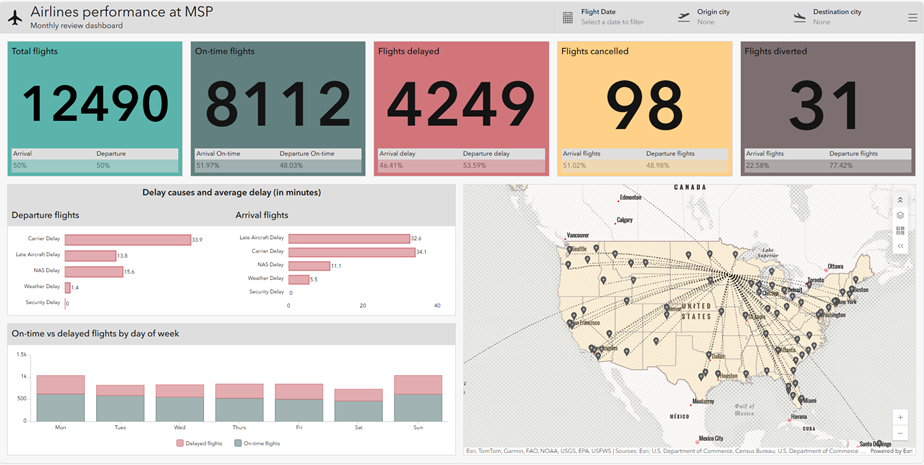</img>

### Discovering dashboard dependencies

The `get_dependencies()` function in the `DashboardManager` class retrieves the dependencies that a dashboard uses, including web maps and scenes, feature layers, embedded apps, and Arcade data expressions. You can optionally retrieve layer IDs and fields by specifying the DependencyOptions object.

In [ ]:
#Get dependencies with layers and fields
options = DependencyOptions(include_layers=True, include_fields=True)
dependencies= dashboard_manager.get_dependencies(options)
dependencies

[ItemResult(item_id='0755d6ca21bf4dcebc3baa1c742336a4', source=None, layers=[LayerResult(id='1994e5200eb-layer-5', sublayer_id=None, fields=[FieldResult(name='OBJECTID'), FieldResult(name='CRSDepTime'), FieldResult(name='DepTime'), FieldResult(name='Diverted'), FieldResult(name='Cancelled'), FieldResult(name='dayOfWeek'), FieldResult(name='delayed'), FieldResult(name='CarrierDelay'), FieldResult(name='LateAircraftDelay'), FieldResult(name='NASDelay'), FieldResult(name='WeatherDelay'), FieldResult(name='SecurityDelay'), FieldResult(name='OriginCityName'), FieldResult(name='DestCityName')]), LayerResult(id='1994e5200e9-layer-4', sublayer_id=None, fields=[FieldResult(name='OBJECTID'), FieldResult(name='CRSArrTime'), FieldResult(name='ArrTime'), FieldResult(name='Cancelled'), FieldResult(name='Diverted'), FieldResult(name='LateAircraftDelay'), FieldResult(name='CarrierDelay'), FieldResult(name='NASDelay'), FieldResult(name='WeatherDelay'), FieldResult(name='SecurityDelay'), FieldResult(nam

### Updating dashboard dependencies

 The `replace_dependencies()` function allows you to update existing dependencies and data sources by replacing them with new ones. The `item_mapping` parameter is a list of `ItemMapping` objects, where each entry maps a source item ID to a target item ID. Within each `ItemMapping`, optional `LayerMapping` and `FieldMapping` objects specify layer-level and field-level details for the replacement.

Here is an example of item_mapping structure -

In [ ]:
#define item mapping
item_mapping = ItemMapping(
            source_item_id="0755d6ca21bf4dcebc3baa1c742336a4",
            target_item_id="32071df690f2434ebe5d40641d53bd21",
            layer_mappings=[
                LayerMapping(
                    source_layer_id='1994e52a6b7-layer-130', # web map operational layer ID
                    target_layer_id='1994aa9cbbd-layer-131', 
                    source_sublayer_id=None,
                    target_sublayer_id=None,
                    field_mappings=[
                        FieldMapping(source_name="ObjectId", target_name="FID"),
                        FieldMapping(source_name="DepTime", target_name="DepartureTime"),
                        FieldMapping(source_name="ArrTime", target_name="ArrivalTime"),
                    ]
                )
            ]
        )

`field_mappings` are optional and only required when the target schema differs from the source. Field replacement is supported for dashboard items with version 4.30.0 and above (i.e, string versions).

When constructing `layer_mappings`,

<ul>
<li>For web map/scene operational layers, use the operational layer ID from the item data (e.g., 1798baf141d-layer-34).</li> 
<li>For standalone services (feature/map image layers), use the service layer ID (0, 1, 2, …).</li>
<li>Include `sublayerId` when a sublayer is used in the map and referenced by the dashboard.</li>
</ul>

Now, pass the item_mapping list to `replace_dependencies()` to swap out dependencies of an existing dashboard.

In [ ]:
#Replace dependencies using item mapping
dashboard_manager.replace_dependencies(item_mapping=[item_mapping])

The `replace_dependencies()` function updates an existing dashboard, making it ideal for scenarios where you need to fix broken data sources or update data with most current information. 

However, if the goal is to simply reuse the design layout and configurations of an existing dashboard and create a copy with different data sources, use the `copy()` function instead. Let's look at how this works below.

### Copying dashboard item

The `copy()` function duplicates an existing dashboard within the same organization. 

> Note: Providing an `ItemMapping` list through the `item_mapping` parameter lets you remap dependencies in the new dashboard; otherwise, the copy will continue to reference the original dependencies.

Optionally, you can specify the title for the new item, tags and the target folder via `title`, `tags` and `folder` parameters respectively.

<Item title:"Airlines Performance at ATL" type:Dashboard owner:api_data_owner>
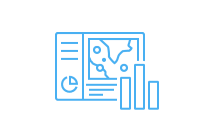

In [ ]:
#Copy dashboard with new mappings
copied_item = dashboard_manager.copy(title="Airlines Performance at ATL", folder="Dashboards", item_mapping=[item_mapping])
copied_item

The screenshot below presents a visual of the copied dashboard, highlighting airlines performance at Atanta airport - 

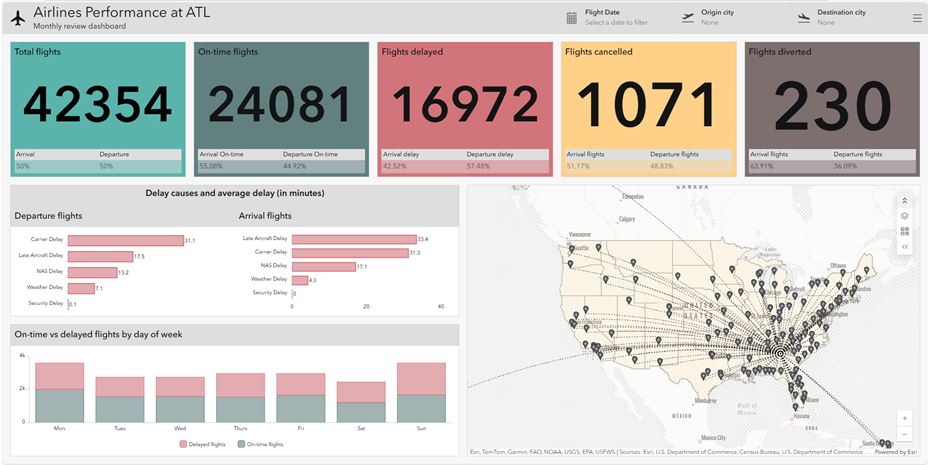</img>

> Tip - If the goal is to clone dashboards from one organization to another, it is recommended to use `clone_items()` as it has also been enhanced to support dashboard items and the remapping of their dependencies.


### Upgrading dashboard item

Use the `upgrade()` function to update a dashboard item to the latest version supported by the portal.

In [ ]:
#Upgrade dashboard
upgraded_dashboard = dashboard_manager.upgrade()

#print upgraded dashboard item data to verify the version
print(upgraded_dashboard.get_data()['version'])

4.34.0
